In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [102]:
from sklearn.metrics import mean_squared_error

In [104]:
import math

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


### 2. Entrenamiento de RNNs en una Serie de Tiempo


En esta seccion emplearemos redes neuronales recurrentes para modelar series de tiempo, es decir una serie de registros (tıpicamente valores reales) regularmente indexados en el tiempo. Parea ello utilizaremos el dataset denominado “international airline passengers” [4]. La tarea consiste en predecir el numero de pasajeros (miles) en vuelos internacionales.

![title](imagenes/nn2.png)

 **Descripcion datos:**
 
 Los datos oscilan entre enero de 1949 y diciembre de 1960, o 12 años, con 144 observaciones.

**(a) Escriba una función que cargue los datos, los divida en conjuntos de entrenamiento y test, los escale.** 

Carga de los datos:

In [7]:
name_f="international-airline-passengers.csv"

In [8]:
dataframe = pd.read_csv(name_f, sep=',', usecols=[1], engine='python', skipfooter=3)
dataframe[:] = dataframe[:].astype('float32') 
df_train, df_test = dataframe[0:96].values, dataframe[96:].values

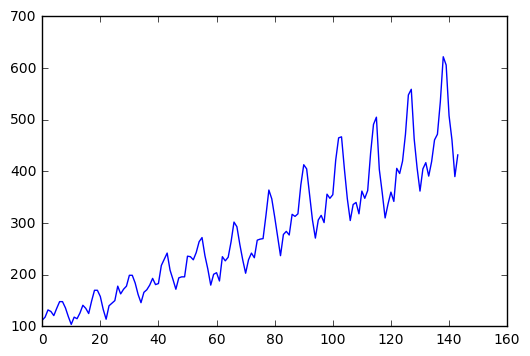

In [9]:
plt.plot(dataset)
plt.show()

Escalamiento de los datos:

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

(b) Ahora nos gustaría manipular los datos, para que hagamos la prediccion de la cantidad de pasajeros para el tiempo siguiente usando la cantidad de pasajeros de los ultimos perıodos de tiempo. El numero de perıodos de tiempos que usaremos se denomina lag. Por ejemplo, tendremos un lag igual a 3, si para predecir el valor xt+1 en el tiempo siguiente usamos la informacion del tiempo actual x y la de los dos periodos anteriores xt-1,xt-2 como variable de entrada.

Realice una funcion que reciba una secuencia de valores y la transforme en dos arreglos dataX (inputs) y dataY(targets) donde el numero de caracteristicas de la matriz de entrada(columnas) sea el numero de periodos de tiempo que se consideran como información(lag).

In [106]:
def create_dataset(dataset,lag=1):
    t_data = len(dataset)
    dataset = dataset.reshape(t_data)
    dataY = dataset[lag:]
    t_dataY = len(dataY)
    dataX = np.zeros((t_dataY, lag))
    for i in range(t_dataY):
        dataX[i] = dataset[i:lag+i]
    return np.array(dataX),np.array(dataY)

In [23]:
def create_dataset_1(dataset, lag=1):
    dataset = dataset.reshape(len(dataset)) 
    dataY = dataset[lag:]
    dataX = np.zeros((len(dataY), lag)) 
    for i in range(len(dataY)):
        dataX[i] = dataset[i:lag+i]
    
    return np.array(dataX), np.array(dataY)

Por ejemplo para **la secuencia [112, 118, 132, 129, 121, 135, 148]**, salida es:

In [18]:
dataset = [112, 118, 132, 129, 121, 135, 148]
dataset =np.array(dataset)
dataX,dataY = create_dataset(dataset, 3)

In [19]:
print(dataX) # podemos vericar la correcta creación para los TrainX

[[ 112.  118.  132.]
 [ 118.  132.  129.]
 [ 132.  129.  121.]
 [ 129.  121.  135.]]


In [20]:
print(dataY) # podemos vericar la correcta creación para los TrainY

[129 121 135 148]


**(c) Usando la función anterior genere los conjuntos de entrenamiento y test para el problema.**

In [107]:
lag=3
trainX, trainY = create_dataset(stream_train_scaled, lag) #creamos los datos de entrenamiento usando la funcion creada
testX, testY = create_dataset(stream_test_scaled, lag)#creamos los datos de testing usando la funcion creada

**(d) En estos momentos tenemos nuestros datos en la forma [ejemplos, atributos]. Sin embargo, la red LSTM necesita que los datos se encuentren en un arreglo de tres dimensiones [samples, time steps, features]. Transforme el train y test sets a la estructura deseada.**

In [108]:
trainX.shape #comprobamos que los datos no estan el formato necesario para la red

(93, 3)

In [109]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) # Tranformacion datos de entrenamiento

In [110]:
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1])) # Tranformacion datos de testing

In [111]:
trainX.shape #comprobamos que los datos quedan en el formato correcto

(93, 1, 3)

**(e) Entrene una LSTM usando un lag de 3**

>**El concepto de "lag" se refiere a  el número de pasos de tiempo anteriores para usar como variables de entrada para predecir el siguiente período de tiempo**

In [112]:
lag = 3

In [113]:
model = Sequential()
#model.add(LSTM(4, activation='tanh', input_shape=(None,lag), recurrent_activation='sigmoid'))
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

/Users/hfarias/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  app.launch_new_instance()
/Users/hfarias/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 3), recurrent_activation="sigmoid")`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 4)                 128       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [114]:
history_lstm = model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)
model.save('modelos/modelo_parte_e.h5')

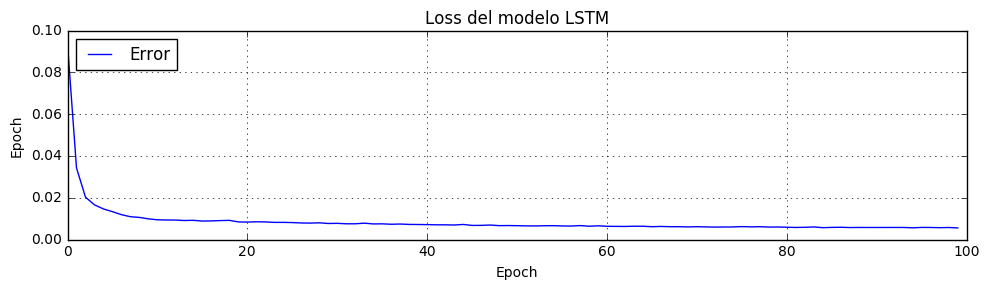

In [115]:
plt.figure(figsize=(10, 3))
#####
#plt.subplot(4, 2, 1)
plt.plot(history_lstm.epoch,history_lstm.history['loss'])  
plt.title('Loss del modelo LSTM')  
plt.ylabel('Epoch')  
plt.xlabel('Epoch')  
plt.legend(['Error'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Podemos ver graficamente como el error va disminuyendo primero muy acentuadamente en los primeros epochs, para despues pasar a una curva mucho mas suave.

**(f) Realice las predicciones del modelo para los conjuntos de entrenamiento y prueba. Denormalice los datos para que el error pueda ser computado en la escala original.**

In [116]:
trainPredict = model.predict(trainX)

In [117]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

In [118]:
testPredict = model.predict(testX)

In [119]:
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

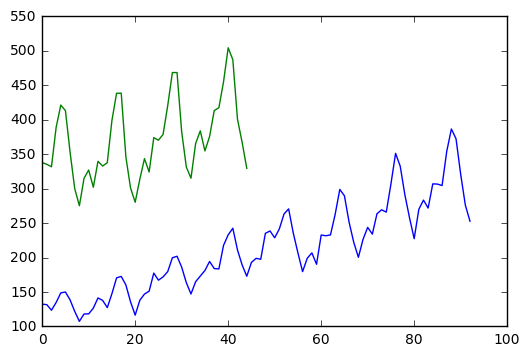

In [129]:
plt.plot(trainPredict)
plt.plot(testPredict)
plt.show()

**(g) Compute el root mean square error (RMSE) sobre los conjuntos de entrenamiento y test.**

In [124]:
 # calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.23 RMSE
Test Score: 65.26 RMSE


Como hemos indicado el objetivo la red es trabajar sobre la linea de tiempo de los pasajeros y vuelos, aca podemos ver los resultados son disimiles pues vemos una diferecia significa en el RMSE, que podria indicar un problema de overffitting.

**(h) Grafique las predicciones del train y test set, y contrastelas con la serie de tiempo original.**

In [125]:
trainPredictPlot = np.empty_like(dataframe.values)

In [126]:
trainPredictPlot[:, :] = np.nan

In [127]:
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

In [128]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict

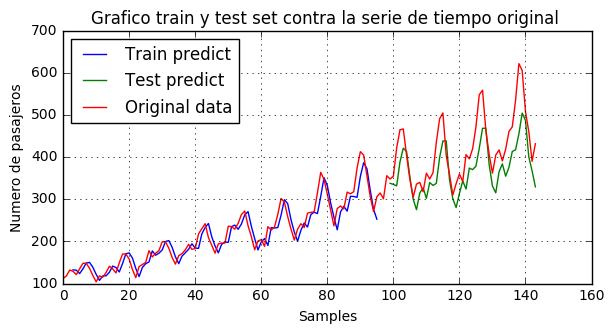

In [143]:
plt.figure(figsize=(15, 15))
#####
plt.subplot(4, 2, 1)
plt.plot(trainPredictPlot) 
plt.plot(testPredictPlot)
plt.plot(dataframe)
plt.title('Grafico train y test set contra la serie de tiempo original ')  
plt.ylabel('Numero de pasajeros')  
plt.xlabel('Samples')  
plt.legend(['Train predict', 'Test predict', 'Original data'], loc='upper left')
plt.grid(True)
plt.show()

Graficamente podemos verificar la afirmación del punto anterior, vale decir la presencia de overfitting pues la curva de los datos de entrenamiento esta casi solapada con los datos reales, situación muy distinta con los datos de testing. Ademas de que podemos ver la claramente, lo cual es interesante, el efecto del lag en la red.